In [1]:
import sys
import torch
import tntorch as tn
import numpy as np
sys.path.append('..')
import lib

In [2]:
# filename = '2020_01_29_stabilizer_dim32_0.dat'
filename = '2019_12_29_haar_dim2_0.dat'
# filename = '2019_12_29_haar_dim4_0.dat'
rho, train_X, train_y = lib.read_data(f'../data/{filename}')
dim = rho.shape[0]
n_qubits = np.log2(dim)

tensor_rank = 2**n_qubits
batch_size = 100
lr = 1e-3

sigma = lib.simulator.randomMixedState(rho.shape[0])
sigma_real, sigma_imag = [tn.Tensor(x, ranks_tt=tensor_rank, requires_grad=True) for x in [np.real(sigma), np.imag(sigma)]]

epoches = 10

Text(0.5, 0, 'b')

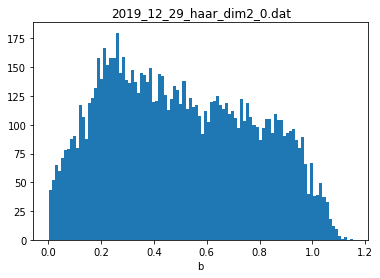

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(train_y, bins=100);
plt.title(filename)
plt.xlabel('b')

In [4]:
def trace(tensor):
    if len(tensor.shape) == 2:
        return sum([tensor[i,i] for i in range(tensor.shape[0])])
    if len(tensor.shape) == 3:
        return sum([tensor[:, i,i] for i in range(tensor.shape[1])])

def cholesky(sigma_real, sigma_imag):
    sigma_real, sigma_imag = sigma_real.dot(sigma_real, k=1)+sigma_imag.dot(sigma_imag, k=1), sigma_real.dot(sigma_imag, k=1)-sigma_imag.dot(sigma_real, k=1)
    trace = sum([sigma_real[i,i] for i in range(rho.shape[0])])
    sigma_real, sigma_imag = [x/trace for x in [sigma_real, sigma_imag]]
    return sigma_real, sigma_imag
    
#initial_trace = sum((np.real(trace(test_X.dot(sigma)))-test_y)**2)

def loss(sigma_real, sigma_imag):
    sigma_real, sigma_imag = cholesky(sigma_real, sigma_imag)
    res = 0
    idx = np.random.choice(np.arange(train_X.shape[0]), batch_size)
    for E_m,y_m in zip(train_X[idx], train_y[idx].astype('float64')):
        E_real, E_imag = [tn.Tensor(x) for x in [np.real(E_m), np.imag(E_m)]]
        res += ((E_real.dot(sigma_real)+E_imag.dot(sigma_imag)-y_m)**2)
#     return res/(initial_trace*train_X.shape[0])
    return res
    

def eval_loss(sigma_real, sigma_imag): # any score function can be used here
    sigma_real_, sigma_imag_ = cholesky(sigma_real, sigma_imag)
    sigma = sigma_real_.torch().detach().cpu().numpy() + 1j*sigma_imag_.torch().detach().cpu().numpy()
    return -lib.fidelity(sigma, rho)

#print('Trace before: %f'%initial_trace)

lib.tn_optimize([sigma_real, sigma_imag], loss, eval_loss, tol=0, patience=3000,print_freq=10,lr=lr)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
iter: 0 |  loss: 1.608236312866211 | eval_loss: -0.6799661689140652 | total time: 0.10964441299438477
iter: 10 |  loss: 1.5504696369171143 | eval_loss: -0.6868618875665876 | total time: 1.6019830703735352
iter: 20 |  loss: 1.4861812591552734 | eval_loss: -0.6869686245687019 | total time: 3.0545268058776855
iter: 30 |  loss: 1.4731067419052124 | eval_loss: -0.6871581313504158 | total time: 4.509401798248291
iter: 40 |  loss: 1.5375347137451172 | eval_loss: -0.6875226059838728 | total time: 5.967213153839111
iter: 50 |  loss: 1.3655145168304443 | eval_loss: -0.6877439661929486 | total time: 7.423892021179199
iter: 60 |  loss: 1.5736812353134155 | eval_loss: -0.6879472648728353 | total time: 8.882713079452515
iter: 70 |  loss: 1.5229367017745972 | eval_loss: -0.6882918668771915 | total time: 10.33545446395874
iter: 80 |  loss: 1.2359296083450317 | eval_loss: -0.6886528467771097 | total tim

iter: 790 |  loss: 0.8911086320877075 | eval_loss: -0.746598509032585 | total time: 115.41852855682373
iter: 800 |  loss: 0.8091474175453186 | eval_loss: -0.7470376552764051 | total time: 116.87769985198975
iter: 810 |  loss: 0.7006524205207825 | eval_loss: -0.7473228661820472 | total time: 118.33582282066345
iter: 820 |  loss: 0.6376281380653381 | eval_loss: -0.7475915469276526 | total time: 119.79565095901489
iter: 830 |  loss: 0.708256185054779 | eval_loss: -0.747661060064 | total time: 121.25275778770447
iter: 840 |  loss: 0.7856545448303223 | eval_loss: -0.7480104909173093 | total time: 122.71927428245544
iter: 850 |  loss: 0.7284711599349976 | eval_loss: -0.748203540892104 | total time: 124.17881298065186
iter: 860 |  loss: 0.7613178491592407 | eval_loss: -0.7485359847155066 | total time: 125.63920259475708
iter: 870 |  loss: 0.7277294397354126 | eval_loss: -0.7489471983700541 | total time: 127.09858560562134
iter: 880 |  loss: 0.7373214960098267 | eval_loss: -0.7498594232600755 

iter: 1580 |  loss: 0.4154095947742462 | eval_loss: -0.7812102820960863 | total time: 230.68182039260864
iter: 1590 |  loss: 0.4148162603378296 | eval_loss: -0.781655700949611 | total time: 232.1409420967102
iter: 1600 |  loss: 0.3648829162120819 | eval_loss: -0.7829532962989271 | total time: 233.59540247917175
iter: 1610 |  loss: 0.41397586464881897 | eval_loss: -0.7827736675079273 | total time: 235.05186223983765
iter: 1620 |  loss: 0.4469964802265167 | eval_loss: -0.781604063889038 | total time: 236.51141619682312
iter: 1630 |  loss: 0.48798421025276184 | eval_loss: -0.7794526638397739 | total time: 237.97024512290955
iter: 1640 |  loss: 0.37265098094940186 | eval_loss: -0.7792685598413038 | total time: 239.4245765209198
iter: 1650 |  loss: 0.4452682435512543 | eval_loss: -0.7795895883187728 | total time: 240.878888130188
iter: 1660 |  loss: 0.28218087553977966 | eval_loss: -0.780758524456388 | total time: 242.33814811706543
iter: 1670 |  loss: 0.3269473910331726 | eval_loss: -0.781

iter: 2370 |  loss: 0.27042561769485474 | eval_loss: -0.7976920777802476 | total time: 345.89299607276917
iter: 2380 |  loss: 0.2221987247467041 | eval_loss: -0.7983177996649006 | total time: 347.3493494987488
iter: 2390 |  loss: 0.2777405381202698 | eval_loss: -0.7988552417210832 | total time: 348.80281829833984
iter: 2400 |  loss: 0.25031736493110657 | eval_loss: -0.7987779318701889 | total time: 350.26217913627625
iter: 2410 |  loss: 0.2714814245700836 | eval_loss: -0.7993579644652445 | total time: 351.71963572502136
iter: 2420 |  loss: 0.23077158629894257 | eval_loss: -0.8001794227586928 | total time: 353.1816666126251
iter: 2430 |  loss: 0.23075416684150696 | eval_loss: -0.8006211518658904 | total time: 354.6362295150757
iter: 2440 |  loss: 0.23172055184841156 | eval_loss: -0.8008885493056596 | total time: 356.09539914131165
iter: 2450 |  loss: 0.22203141450881958 | eval_loss: -0.8010498868173809 | total time: 357.5523431301117
iter: 2460 |  loss: 0.15850357711315155 | eval_loss: 

iter: 3160 |  loss: 0.15799738466739655 | eval_loss: -0.8125744506940044 | total time: 461.12562346458435
iter: 3170 |  loss: 0.21478448808193207 | eval_loss: -0.8137668981083296 | total time: 462.5892765522003
iter: 3180 |  loss: 0.1882113814353943 | eval_loss: -0.813487038659258 | total time: 464.04412841796875
iter: 3190 |  loss: 0.20798997581005096 | eval_loss: -0.8126642851899103 | total time: 465.5012454986572
iter: 3200 |  loss: 0.25198203325271606 | eval_loss: -0.8131471297818401 | total time: 466.9629776477814
iter: 3210 |  loss: 0.13990335166454315 | eval_loss: -0.8133151763272651 | total time: 468.4223883152008
iter: 3220 |  loss: 0.17419931292533875 | eval_loss: -0.8129555298164127 | total time: 469.877911567688
iter: 3230 |  loss: 0.17217953503131866 | eval_loss: -0.8134159813864175 | total time: 471.33601474761963
iter: 3240 |  loss: 0.18002261221408844 | eval_loss: -0.8135319610381769 | total time: 472.800164937973
iter: 3250 |  loss: 0.1652023047208786 | eval_loss: -0.8

iter: 3950 |  loss: 0.2076483815908432 | eval_loss: -0.8230502812561764 | total time: 576.368980884552
iter: 3960 |  loss: 0.1808450073003769 | eval_loss: -0.8224672464351676 | total time: 577.8272452354431
iter: 3970 |  loss: 0.19284456968307495 | eval_loss: -0.8210968910895058 | total time: 579.2842800617218
iter: 3980 |  loss: 0.1622382402420044 | eval_loss: -0.8208089464312412 | total time: 580.739994764328
iter: 3990 |  loss: 0.15046274662017822 | eval_loss: -0.8210520845709355 | total time: 582.1997516155243
iter: 4000 |  loss: 0.17277584969997406 | eval_loss: -0.8225875903689024 | total time: 583.6602411270142
iter: 4010 |  loss: 0.1946294605731964 | eval_loss: -0.8222108002144717 | total time: 585.1160006523132
iter: 4020 |  loss: 0.19259706139564514 | eval_loss: -0.8224730978335767 | total time: 586.5749850273132
iter: 4030 |  loss: 0.11597391963005066 | eval_loss: -0.8218418126514745 | total time: 588.0376329421997
iter: 4040 |  loss: 0.20477072894573212 | eval_loss: -0.82099

iter: 4740 |  loss: 0.19607028365135193 | eval_loss: -0.825046714970256 | total time: 691.717324256897
iter: 4750 |  loss: 0.1615283340215683 | eval_loss: -0.8252054229648789 | total time: 693.1762003898621
iter: 4760 |  loss: 0.12414683401584625 | eval_loss: -0.824786427422978 | total time: 694.6370055675507
iter: 4770 |  loss: 0.16928526759147644 | eval_loss: -0.8244538252013273 | total time: 696.0972900390625
iter: 4780 |  loss: 0.13594186305999756 | eval_loss: -0.8235220659010238 | total time: 697.5576386451721
iter: 4790 |  loss: 0.16209553182125092 | eval_loss: -0.8239646418281743 | total time: 699.0177114009857
iter: 4800 |  loss: 0.27991563081741333 | eval_loss: -0.8243733631514006 | total time: 700.4789690971375
iter: 4810 |  loss: 0.13540558516979218 | eval_loss: -0.824830092084705 | total time: 701.9355235099792
iter: 4820 |  loss: 0.2330918312072754 | eval_loss: -0.8238276463051507 | total time: 703.3961436748505
iter: 4830 |  loss: 0.19804179668426514 | eval_loss: -0.82329

iter: 5530 |  loss: 0.15441234409809113 | eval_loss: -0.8262145944034013 | total time: 806.9511027336121
iter: 5540 |  loss: 0.15129652619361877 | eval_loss: -0.8260385200985708 | total time: 808.4117996692657
iter: 5550 |  loss: 0.17505617439746857 | eval_loss: -0.8261151765462669 | total time: 809.8706209659576
iter: 5560 |  loss: 0.12786561250686646 | eval_loss: -0.825317580150675 | total time: 811.3287646770477
iter: 5570 |  loss: 0.17765827476978302 | eval_loss: -0.8248492416126786 | total time: 812.7858936786652
iter: 5580 |  loss: 0.16182203590869904 | eval_loss: -0.8243619128818604 | total time: 814.2444067001343
iter: 5590 |  loss: 0.18401430547237396 | eval_loss: -0.8239894910488769 | total time: 815.7046875953674
iter: 5600 |  loss: 0.18788325786590576 | eval_loss: -0.8241837518122179 | total time: 817.1626467704773
iter: 5610 |  loss: 0.19993533194065094 | eval_loss: -0.8237326987975271 | total time: 818.6187756061554
iter: 5620 |  loss: 0.23387876152992249 | eval_loss: -0.

iter: 6320 |  loss: 0.19478808343410492 | eval_loss: -0.8249437196440125 | total time: 922.2209618091583
iter: 6330 |  loss: 0.1559242606163025 | eval_loss: -0.8247733945122033 | total time: 923.6766123771667
iter: 6340 |  loss: 0.19157975912094116 | eval_loss: -0.824739774085883 | total time: 925.1321492195129
iter: 6350 |  loss: 0.1993054747581482 | eval_loss: -0.8249123819182894 | total time: 926.5929641723633
iter: 6360 |  loss: 0.21285352110862732 | eval_loss: -0.8246704118710603 | total time: 928.0515992641449
iter: 6370 |  loss: 0.21492189168930054 | eval_loss: -0.8238711992786719 | total time: 929.516149520874
iter: 6380 |  loss: 0.12903162837028503 | eval_loss: -0.8246437381927719 | total time: 930.9749157428741
iter: 6390 |  loss: 0.16178369522094727 | eval_loss: -0.8248166934790799 | total time: 932.4345576763153
iter: 6400 |  loss: 0.14063817262649536 | eval_loss: -0.8253218790898161 | total time: 933.8934433460236
iter: 6410 |  loss: 0.15153242647647858 | eval_loss: -0.825

iter: 7110 |  loss: 0.16611561179161072 | eval_loss: -0.8232275278919688 | total time: 1037.4212510585785
iter: 7120 |  loss: 0.16574910283088684 | eval_loss: -0.8247406830407589 | total time: 1038.877368927002
iter: 7130 |  loss: 0.19337499141693115 | eval_loss: -0.8264266395322052 | total time: 1040.33634018898
iter: 7140 |  loss: 0.21863114833831787 | eval_loss: -0.8265796298556154 | total time: 1041.7916388511658
iter: 7150 |  loss: 0.17864899337291718 | eval_loss: -0.826944091778369 | total time: 1043.2461824417114
iter: 7160 |  loss: 0.19211415946483612 | eval_loss: -0.8261844214911487 | total time: 1044.7056956291199
iter: 7170 |  loss: 0.13360147178173065 | eval_loss: -0.8255601677928456 | total time: 1046.158002614975
iter: 7180 |  loss: 0.171951562166214 | eval_loss: -0.8251021595673121 | total time: 1047.613071680069
iter: 7190 |  loss: 0.17571868002414703 | eval_loss: -0.8255084491733629 | total time: 1049.0655868053436
iter: 7200 |  loss: 0.14756835997104645 | eval_loss: -

iter: 7890 |  loss: 0.1465807557106018 | eval_loss: -0.8238515441625099 | total time: 1150.937171459198
iter: 7900 |  loss: 0.18205749988555908 | eval_loss: -0.8249044880485058 | total time: 1152.3937814235687
iter: 7910 |  loss: 0.1672612875699997 | eval_loss: -0.8264377701509629 | total time: 1153.849268913269
iter: 7920 |  loss: 0.15389816462993622 | eval_loss: -0.8266997474097352 | total time: 1155.301552772522
iter: 7930 |  loss: 0.16184766590595245 | eval_loss: -0.8265717260658131 | total time: 1156.7552182674408
iter: 7940 |  loss: 0.2193736732006073 | eval_loss: -0.8259913118317779 | total time: 1158.2112038135529
iter: 7950 |  loss: 0.1816369593143463 | eval_loss: -0.8246102241121164 | total time: 1159.6628386974335
iter: 7960 |  loss: 0.12665770947933197 | eval_loss: -0.8238483612213007 | total time: 1161.1178305149078
iter: 7970 |  loss: 0.164009690284729 | eval_loss: -0.824878417697226 | total time: 1162.5798902511597
iter: 7980 |  loss: 0.14906354248523712 | eval_loss: -0.

iter: 8670 |  loss: 0.1560802012681961 | eval_loss: -0.8252178527334542 | total time: 1264.5942821502686
iter: 8680 |  loss: 0.16548041999340057 | eval_loss: -0.8253082239976393 | total time: 1266.0506074428558
iter: 8690 |  loss: 0.17621682584285736 | eval_loss: -0.8249643354021599 | total time: 1267.5116708278656
iter: 8700 |  loss: 0.09534123539924622 | eval_loss: -0.8250195653696272 | total time: 1268.9676494598389
iter: 8710 |  loss: 0.18812620639801025 | eval_loss: -0.8254779281749889 | total time: 1270.4219744205475
iter: 8720 |  loss: 0.1293599158525467 | eval_loss: -0.8246983720365213 | total time: 1271.8781712055206
iter: 8730 |  loss: 0.14036235213279724 | eval_loss: -0.824146110208312 | total time: 1273.3384952545166
iter: 8740 |  loss: 0.15081042051315308 | eval_loss: -0.8240317962093271 | total time: 1274.7992169857025
iter: 8750 |  loss: 0.12117932736873627 | eval_loss: -0.8235605849224193 | total time: 1276.2597842216492
iter: 8760 |  loss: 0.15569370985031128 | eval_lo

iter: 9450 |  loss: 0.17347250878810883 | eval_loss: -0.8259338418080636 | total time: 1378.3174812793732
iter: 9460 |  loss: 0.15135250985622406 | eval_loss: -0.8251866708189237 | total time: 1379.7729716300964
iter: 9470 |  loss: 0.21720772981643677 | eval_loss: -0.8255346213570054 | total time: 1381.232970237732
iter: 9480 |  loss: 0.1307029128074646 | eval_loss: -0.8253258430849347 | total time: 1382.686199426651
iter: 9490 |  loss: 0.19382889568805695 | eval_loss: -0.8238624922074712 | total time: 1384.1459505558014
iter: 9500 |  loss: 0.16134989261627197 | eval_loss: -0.8244100401055989 | total time: 1385.6039538383484
iter: 9510 |  loss: 0.21661292016506195 | eval_loss: -0.8242995798818691 | total time: 1387.0633854866028
iter: 9520 |  loss: 0.15580767393112183 | eval_loss: -0.8234850959613202 | total time: 1388.5220985412598
iter: 9530 |  loss: 0.13168025016784668 | eval_loss: -0.8239360458947078 | total time: 1389.9782917499542
iter: 9540 |  loss: 0.16505269706249237 | eval_lo

In [5]:
sigma_real_, sigma_imag_ = cholesky(sigma_real, sigma_imag)
sigma = sigma_real_.torch().detach().cpu().numpy() + 1j*sigma_imag_.torch().detach().cpu().numpy()
sigma /= sum([sigma[i,i] for i in range(int(2**n_qubits))])
lib.fidelity(sigma, rho)

0.7776961574671735